In [2]:
import os
import numpy as np
import healpy as hp
import camb
import pylab as pl
%matplotlib inline

import plancklens
from plancklens import utils
cls_path = os.path.join(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

cl_unl = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_ten = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wtensors_tensCls.dat'))

r_in = lambda idx: 0.003 if idx%2 == 0 else 0. # input tensor mode


# build predictions of the lensed spectra, inclusive of the truncation of the unlensed fields at 5120
from camb.correlations import lensed_cls
lmax_unl = 5120
cls_camb = np.zeros((lmax_unl+1, 4), dtype=float)
cldd = cl_unl['pp'][:lmax_unl+1] * np.arange(lmax_unl+1) ** 2 * (np.arange(1, lmax_unl+2, dtype=float)) ** 2 / (2 * np.pi)
ls = np.arange(lmax_unl+1)
wls =  (ls * (ls + 1)) / (2 * np.pi)
for ix, spec in enumerate(['tt', 'ee', 'bb', 'te']):
    cls_camb[:, ix] = cl_unl[spec][ls] * wls
cl_len_5120 = lensed_cls(cls_camb, cldd, lmax=lmax_unl, lmax_lensed=4096)
cl_len_5120 = {spec: cl_len_5120[:, ix] * utils.cli(wls[:4097]) for ix, spec in enumerate(['tt', 'ee', 'bb', 'te'])}


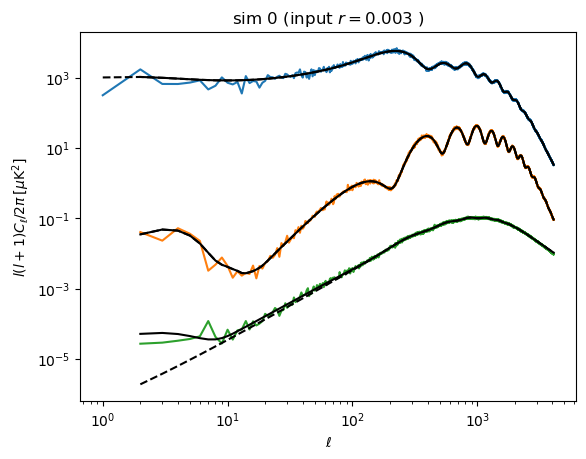

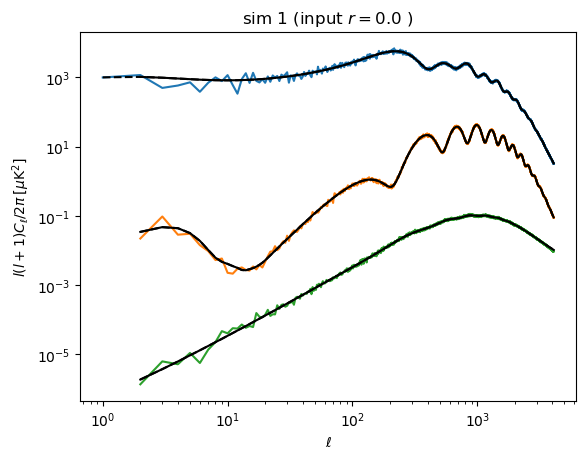

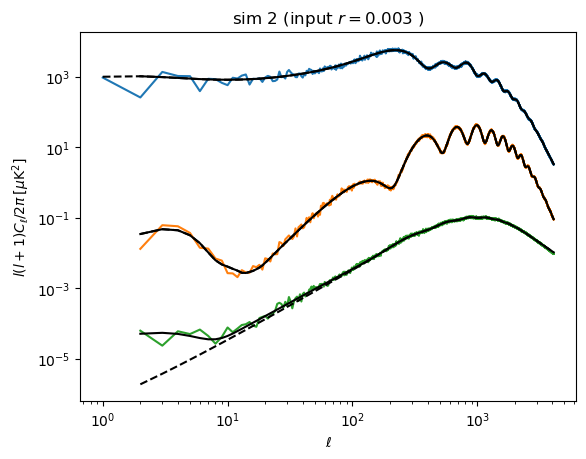

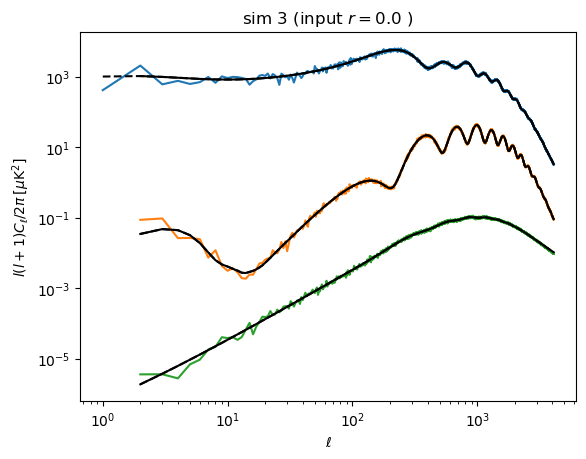

In [2]:
# TEB auto spectra, single sims
for idx in [0, 1, 2, 3]:
    pl.figure()
    TEB = np.load('/global/cfs/cdirs/cmbs4xlb/v1/cmb/lcdm_teb_%04d.npy'%idx)
    wls = lambda ls : ls * (ls + 1) / (2 * np.pi)
    for i, (X, lab) in enumerate(zip(TEB, 'teb')):
        ls = np.arange(1 + (i > 0), 4097)
        ln = pl.loglog(ls, wls(ls) *  hp.alm2cl(X, X)[ls])
        pl.plot(ls, wls(ls) * cl_len[lab + lab][ls], c='k', ls='--')
        ls = np.arange(2, 4097) # No dipole tensor signal
        pl.plot(ls, wls(ls) * (cl_len[lab + lab][ls] + (r_in(idx) / 0.01) * cl_ten[lab + lab][ls]), c='k')
    pl.xlabel('$\ell$')
    pl.ylabel(r'$l(l + 1)C_\ell / 2\pi \: [\mu \rm{K}^2]$')
    pl.title('sim ' + str(idx)  + ' (input $r = %s$ )'%(r_in(idx)) )
    pl.show()

 [00:11:57]  ---------> 99%


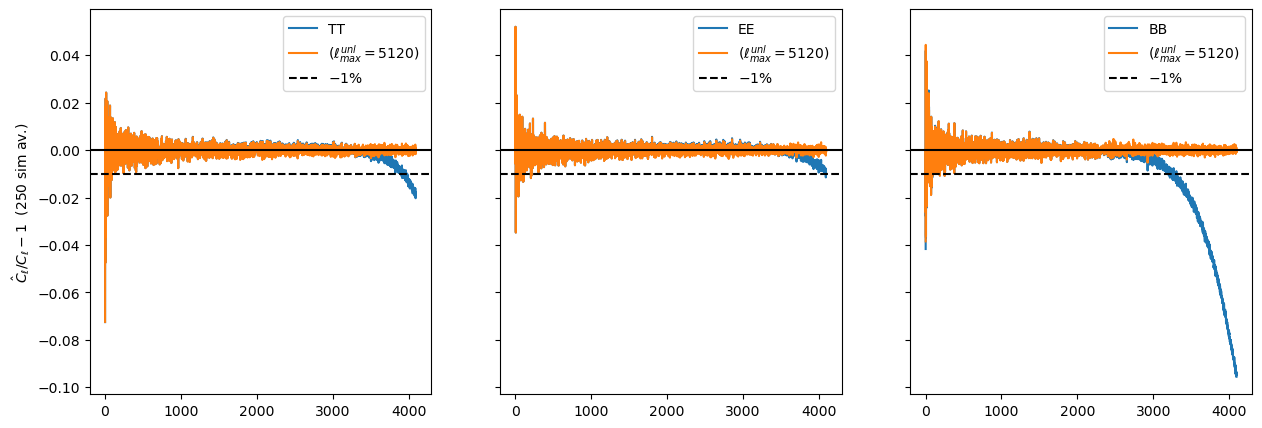

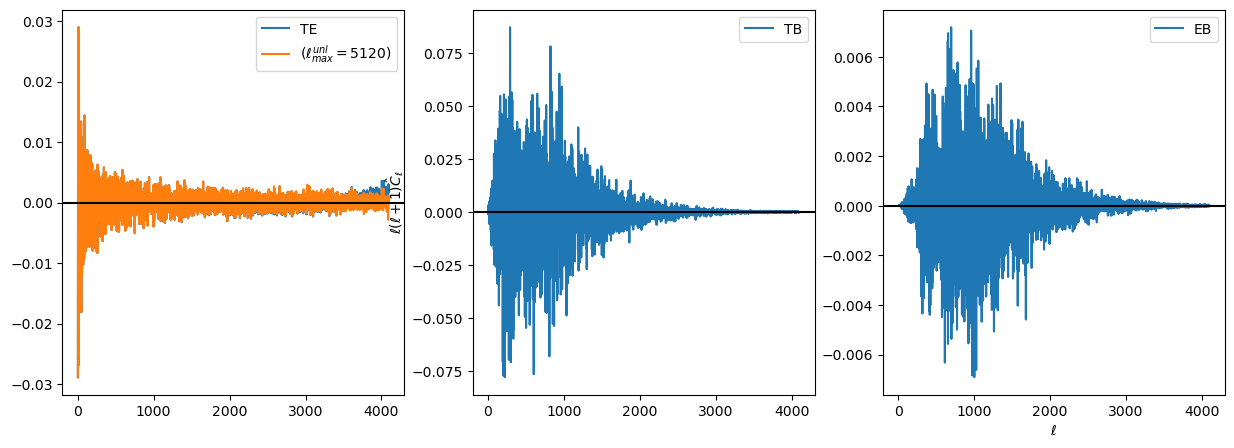

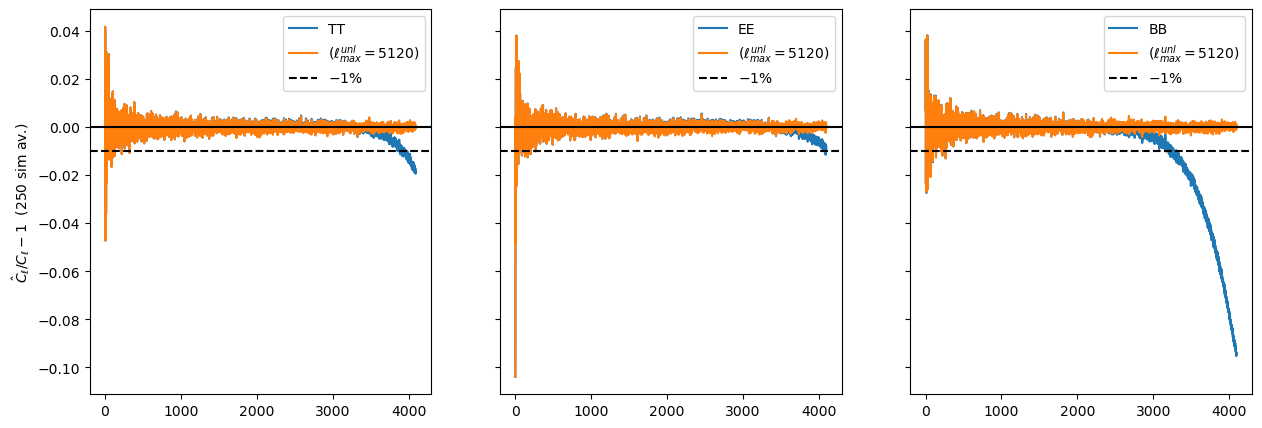

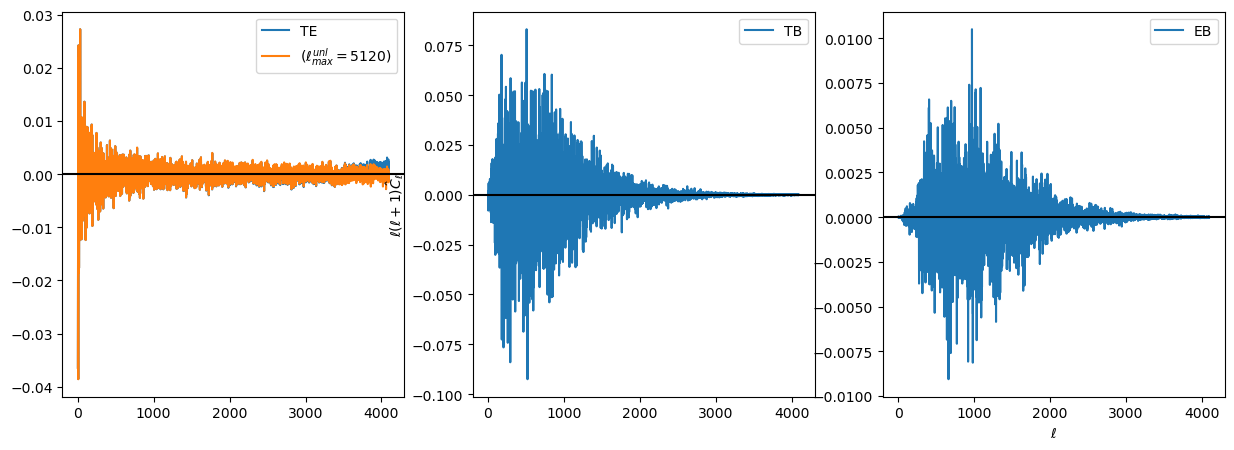

In [3]:
# Some more precise stats:
import glob
TEBs = glob.glob('/global/cfs/cdirs/cmbs4xlb/v1/cmb/lcdm_teb_????.npy')
TEBm  = np.zeros((3, hp.Alm.getsize(4096), 2), dtype=complex)  # even and odds sims
counts = np.zeros(2, dtype=int)
imax = 500
cls_odd = {spec: np.zeros(4097, dtype=float) for spec in ['tt', 'te', 'tb', 'ee', 'eb', 'bb']}
cls_eve = {spec: np.zeros(4097, dtype=float) for spec in ['tt', 'te', 'tb', 'ee', 'eb', 'bb']}

for i, TEBfn in utils.enumerate_progress(TEBs):
    idx = int(TEBfn[-8:-4])
    if idx <= imax:
        counts[idx%2] += 1
        this_cls = cls_odd if idx%2 else cls_eve
        TEB = np.load(TEBfn)
        for ix, x in enumerate('teb'):
            for iy, y in enumerate('teb'):
                if ix <= iy:
                    this_cls[x + y] += hp.alm2cl(TEB[ix], TEB[iy])
                    
for cl in cls_eve.values(): cl /= counts[0]
for cl in cls_odd.values(): cl /= counts[1]

# Odd and even sims sim average deviation
for cls, r in zip([cls_odd, cls_eve], [r_in(1), r_in(0)]):
    fig, axes = pl.subplots(1, 3, figsize=(15, 5), sharey=True)
    for ax, spec in zip(axes, ['tt', 'ee', 'bb']):
        pl.sca(ax)
        ls = np.arange(2, 4097)
        pred = cl_len[spec][ls] + (r / 0.01) * cl_ten[spec][ls]
        pred_5120 = cl_len_5120[spec][ls] + (r / 0.01) * cl_ten[spec][ls]
        ax.plot(ls, cls[spec][ls] / pred - 1., label=spec.upper())
        ax.plot(ls, cls[spec][ls] / pred_5120 - 1., label='$(\ell^{unl}_{max} = 5120$)')
        ax.axhline(-0.01, c='k', ls='--', label='$-1\%$')
        ax.axhline(0, c='k')
        pl.legend()
    axes[0].set_ylabel(r'$\hat C_\ell / C_\ell - 1$  (%s sim av.)'%(counts[1]) )
    pl.subplots_adjust()

    fig, axes = pl.subplots(1, 3, figsize=(15, 5))
    spec = 'te'
    pred = cl_len[spec][ls] + (r / 0.01) * cl_ten[spec][ls]
    pred_5120 = cl_len_5120[spec][ls] + (r / 0.01) * cl_ten[spec][ls]
    norm = np.sqrt(cl_len['tt'][ls] * cl_len['ee'][ls]) 
    axes[0].plot(ls, (cls[spec][ls]  - pred) / norm, label=spec.upper())
    axes[0].plot(ls, (cls[spec][ls]  - pred_5120) / norm, label='$(\ell^{unl}_{max} = 5120$)')
    axes[0].axhline(0, c='k')

    axes[0].legend()
    for ax, spec in zip(axes[1:], ['tb', 'eb']):
        pl.sca(ax)
        ax.plot(ls, cls[spec][ls] * (ls  * (ls + 1.)) /2/np.pi, label=spec.upper())
        ax.axhline(0, c='k')
        pl.legend()
    axes[1].set_ylabel(r'$\ell (\ell + 1) \hat C_\ell$')

    pl.xlabel(r'$\ell$')
    pl.subplots_adjust()

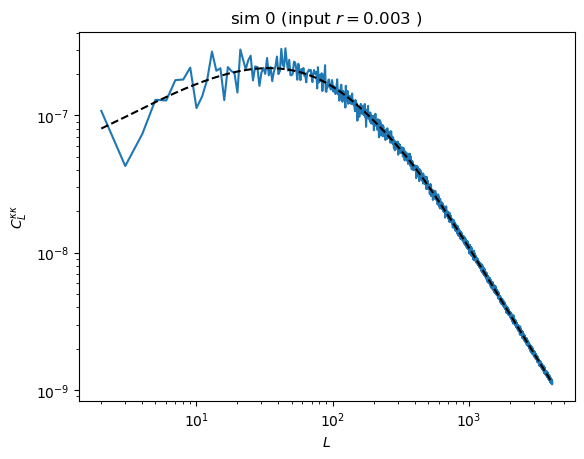

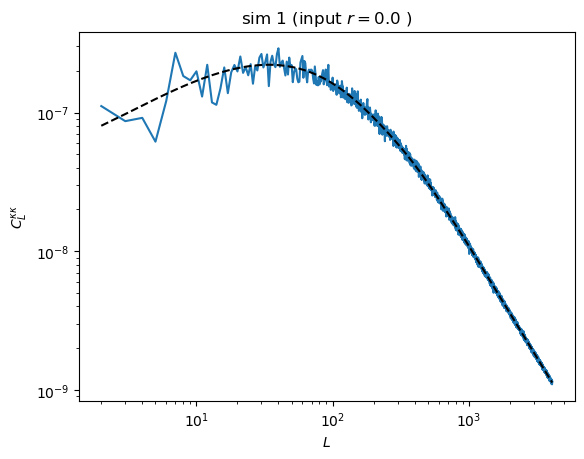

In [4]:
# kappa auto spectra, single sims
for idx in [0, 1]:
    pl.figure()
    k = np.load('/global/cfs/cdirs/cmbs4xlb/v1/cmb/lcdm_k_%04d.npy'%idx)
    wls = lambda ls : ls ** 2 * (ls + 1.) ** 2* 0.25 
    ln = pl.loglog(ls, hp.alm2cl(k, k)[ls])
    pl.plot(ls, wls(ls) * cl_unl['pp'][ls], c='k', ls='--')
    pl.xlabel('$L$')
    pl.ylabel(r'$C_L^{\kappa\kappa}$')
    pl.title('sim ' + str(idx)  + ' (input $r = %s$ )'%(r_in(idx)) )
    pl.show()

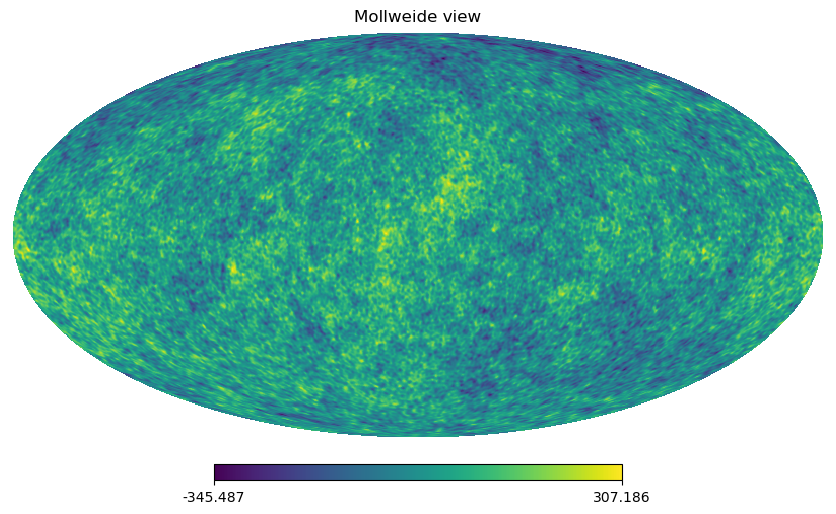

In [3]:
try:
    import maps
except:
    import sys #
    if '..' not in sys.path:
        sys.path.insert(0, '..')
    import maps

# Example getting a LiteBird map:

simulation_index = 0 # there are 500 sims from 0 to 499
litebird_band = 'L1-060'
T = maps.get_lb_map(litebird_band, simulation_index, job='T') # Other 'jobs' can be 'QU' or 'TQU'
hp.mollview(T[0])

In [4]:
# Possible band inputs are:
print('List of LiteBird bands:')
print(maps.lb['tag'])

print('List of S4 bands:')
print(maps.s4['band'])

List of LiteBird bands:
 tag  
------
H3-402
H2-337
H1-280
H2-235
H1-195
M1-195
M2-166
M1-140
M2-119
M1-100
L4-140
L3-119
L4-100
L2-089
L3-089
L1-078
L4-078
L2-068
L3-068
L1-060
L2-050
L1-040
List of S4 bands:
   band   
----------
SPLAT_f020
CHLAT_f030
SPLAT_f030
CHLAT_f040
SPLAT_f040
SPLAT_f090
CHLAT_f090
CHLAT_f150
SPLAT_f150
CHLAT_f220
SPLAT_f220
CHLAT_f280
SPLAT_f280
  SAT_f030
  SAT_f040
  SAT_f085
  SAT_f095
  SAT_f145
  SAT_f155
  SAT_f220
  SAT_f280


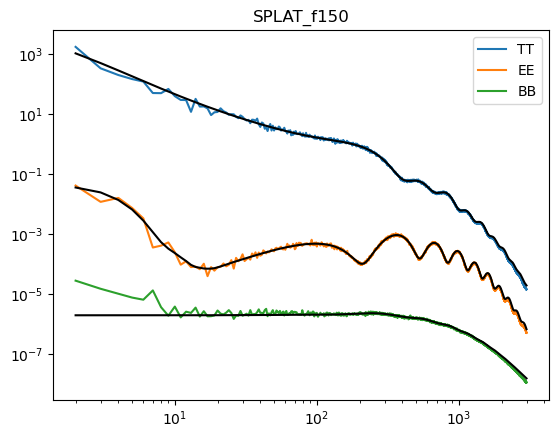

In [8]:
# Same for a S4 map:
band = 'SPLAT_f150'
lmax = 3000
job = 'TQU'
simulation_index = 0 # there are 500 sims from 0 to 499


TQU = maps.get_s4_map(band, simulation_index, job=job)

ls = np.arange(2, lmax + 1)

if 'T' in job:
    T = hp.map2alm(TQU[0], lmax=lmax, iter=0)
    pl.loglog(ls, hp.alm2cl(T)[ls], label='TT')
    pl.plot(ls, cl_len['tt'][ls], c='k')

if 'QU' in job:
    EB = hp.map2alm_spin(TQU[1:], 2, lmax)

    pl.loglog(ls, hp.alm2cl(EB)[0][ls], label='EE')
    pl.loglog(ls, hp.alm2cl(EB)[1][ls], label='BB')
    pl.plot(ls, cl_len['ee'][ls], c='k')
    pl.plot(ls, cl_len['bb'][ls], c='k')

pl.title(band)
pl.legend()